# Set Up

In [1]:
# Basic imports
import os
import random
import importlib
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
load_data()

,Price,DXY,DFII10,VIX,CPI,Sentiment_Score,Exponential_Weighted_Score,EMA30,EMA252,RSI,Upper_Band,Lower_Band
Date,,,,,,,,,,,,
2003-01-02,343.8,102.980003,2.43,25.389999,181.700,0.000000,1.150043,344.140157,344.140157,68.471338,356.212795,320.207205
2003-01-03,344.5,102.470001,2.43,24.680000,181.700,0.000000,1.112340,344.464016,344.464016,68.370607,356.359128,321.930872
2003-01-06,351.8,101.970001,2.46,24.910000,181.700,-0.063408,0.738865,351.066402,351.066402,69.631902,357.243318,323.716682
2003-01-07,349.0,102.570000,2.42,25.129999,181.700,0.000000,0.714642,349.206640,349.206640,65.988372,356.796231,326.753769
2003-01-08,349.8,101.870003,2.29,25.530001,181.700,0.000000,0.691213,349.740664,349.740664,58.510638,356.013836,330.086164
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-28,1302.2,95.750000,0.97,18.870001,251.712,0.002602,1.111991,1301.264310,1301.264310,64.093357,1300.345239,1275.274761
2019-01-29,1307.6,95.820000,0.94,19.129999,251.712,0.000000,1.075535,1306.966431,1306.966431,66.101695,1303.890367,1274.589633
2019-01-30,1310.7,95.339996,0.86,17.660000,251.712,0.385747,1.426022,1310.326643,1310.326643,65.986395,1307.805270,1273.454730


# Data Processing

# Training & Test Split

In [3]:
def prepare_training_data(data, seq_length, train_ratio=0.80, features = ["Price"]):
    """
    Extract feature columns and split data into training and testing sets.
    
    Parameters:
        data (DataFrame): Preprocessed data
        train_ratio (float): Ratio of data to use for training (default: 0.95)
        
    Returns:
        tuple: (training data, test data, scaler)
    """
    data = data[features].copy().dropna()
    dataset = data.values
    
    # Determine train/test split point
    training_size = int(np.ceil(len(dataset) * train_ratio))
    
    # Scale the data
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    train_data = dataset[:training_size]
    test_data = dataset[training_size - seq_length:]
    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    
    return scaled_train_data, scaled_test_data, scaler

In [4]:
def create_sequences(data, seq_length, target_col=0):
    """
    Create sequences for LSTM model input with multiple features.
    
    Parameters:
        data (ndarray): Input data array where columns are features
        seq_length (int): Length of sequence for LSTM input
        target_col (int): Index of the target column to predict
        
    Returns:
        tuple: (X sequences, y targets)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col].reshape(1))
    
    return np.array(X), np.array(y)

# Model

In [5]:
def directional_mse_loss(alpha=0.5):
    def loss(y_true, y_pred):
        # Calculate MSE component manually
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # For directional component, we need to reshape y_true and y_pred
        # as they are 1D in your backtesting context
        # Get true values for current and previous time steps
        y_true_current = y_true[1:]
        y_true_prev = y_true[:-1]
        
        # Get predicted values for current and previous time steps
        y_pred_current = y_pred[1:]
        y_pred_prev = y_pred[:-1]
        
        # Calculate directional component
        true_diff = y_true_current - y_true_prev
        pred_diff = y_pred_current - y_pred_prev
        
        # Get signs of differences
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        
        # Calculate direction agreement (1 when directions match, 0 otherwise)
        dir_agree = tf.cast(tf.equal(true_sign, pred_sign), tf.float32)
        dir_loss = 1.0 - tf.reduce_mean(dir_agree)
        
        # Combine losses with weighting factor alpha
        return alpha * mse + (1 - alpha) * dir_loss
    
    return loss

# Evaluation

In [6]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [7]:
def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100


In [8]:
def evaluate_model(model, X_test, y_test, scaler, target_col=0):
    """
    Evaluate model performance on test data with multiple features.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets (single column)
        scaler: Fitted scaler for inverse transformation
        target_col (int): Index of the target column
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    # Create templates for inverse transformation
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    pred_template = np.zeros((len(pred), scaler.n_features_in_))
    
    # Place the predictions and actual values in the right column
    y_test_template[:, target_col] = y_test.flatten()
    pred_template[:, target_col] = pred.flatten()
    
    # Inverse transform to get actual values
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    pred_inv = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv,
        'pred': pred_inv
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    mse = mean_squared_error(test['actual'], test['pred'])
    rmse = root_mean_squared_error(test['actual'], test['pred'])
    directional_acc = directional_accuracy(test['actual'], test['pred'])

    from sklearn.metrics import r2_score
    r2 = r2_score(test['actual'], test['pred'])
    
    return test, mape, mse, rmse, directional_acc, r2

In [9]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [10]:
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# Run

# Hyperparameter Tuning

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

def select_features(data, target_column="Price", method="random_forest", k=5):
    """
    Selects top k important features.
    
    Parameters:
        data (DataFrame): The input dataset
        target_column (str): Name of the target variable
        method (str): "random_forest"
        k (int): Number of best features to select
        
    Returns:
        DataFrame: Dataset with selected features
    """
    X = data.drop(columns=[target_column]) 
    y = data[target_column]
    
    if method == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        feature_importances = model.feature_importances_
    else:
        raise ValueError("Choose different feature selection method")
    
    selected_features = X.columns[np.argsort(feature_importances)[-k:]]
    
    print(f"Selected Features ({method}): {selected_features.tolist()}")
    
    return data[[target_column] + selected_features.tolist()]


Selected Features (random_forest): ['Exponential_Weighted_Score', 'Lower_Band', 'Upper_Band', 'EMA252', 'EMA30']
Reloading Tuner from keras_tuner_dir/lstm_hyperparams/tuner0.json
Best hyperparameters:
num_lstm_layers: 2
lstm_units_0: 128
dense_units: 192
l2_reg: 0.0007828301614945718
dropout_rate: 0.5
learning_rate: 0.0061644040654393415
lstm_units_1: 64
Epoch 1/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1754 - root_mean_squared_error: 0.2950 - val_loss: 0.0446 - val_root_mean_squared_error: 0.0143 - learning_rate: 0.0062
Epoch 2/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0409 - root_mean_squared_error: 0.0490 - val_loss: 0.0252 - val_root_mean_squared_error: 0.0281 - learning_rate: 0.0062
Epoch 3/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0237 - root_mean_squared_error: 0.0493 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0487 - learning_rate: 0.0062
Epoch 4/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0144 - root_mean_squared_error: 0.0490 

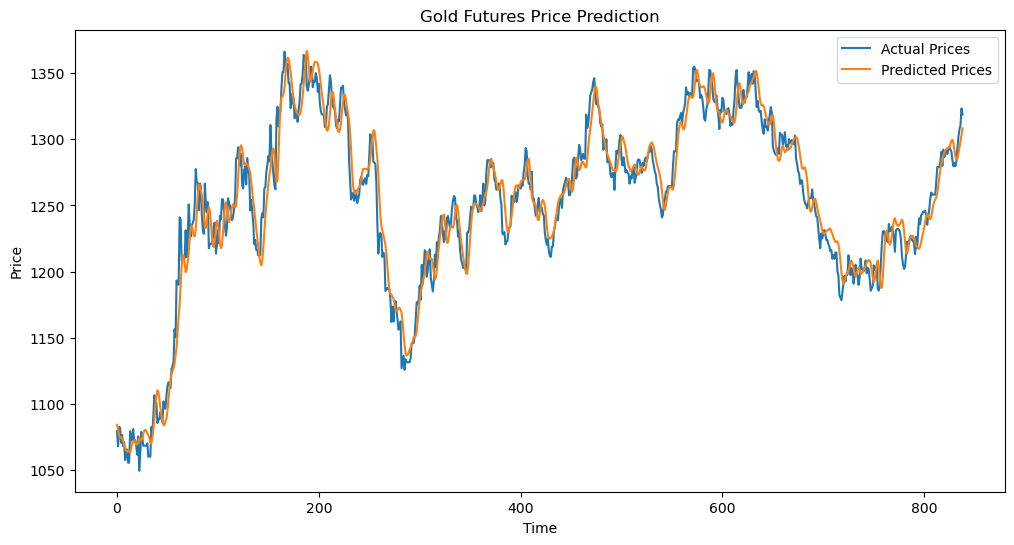

In [14]:
def build_tunable_model(hp, input_shape):
    """
    Build a model with tunable hyperparameters.
    
    Parameters:
        hp: Hyperparameter object from Keras Tuner
        input_shape: Shape of input data
        
    Returns:
        Model: Compiled LSTM model with tunable parameters
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    """    # Tune LSTM units
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units_1, return_sequences=True))
    
    lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=lstm_units_2))
    """
    # Tune number of LSTM layers: 1 to 3
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3)

    for i in range(num_layers):
        units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32)
        return_sequences = True if i < num_layers - 1 else False
        model.add(LSTM(units=units, return_sequences=return_sequences))

    
    # Tune dense layer units
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    
    # Tune L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')
    model.add(Dense(dense_units, kernel_regularizer=regularizers.L2(l2_reg)))
    
    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError()])
    #try 
    return model

def tune_hyperparameters(X_train, y_train, input_shape, max_trials=10):
    """
    Perform hyperparameter tuning using Keras Tuner.
    
    Parameters:
        X_train: Training features
        y_train: Training targets
        input_shape: Shape of input data
        max_trials: Maximum number of trials to run
        
    Returns:
        tuple: (best hyperparameters, best model)
    """
    import keras_tuner as kt
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    # Create a wrapper function to pass input_shape to the model builder
    def model_builder(hp):
        return build_tunable_model(hp, input_shape)
    
    # Define the tuner
    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='keras_tuner_dir',
        project_name='lstm_hyperparams'
    )
    
    # Alternatively, you can use other tuners:
    # tuner = kt.Hyperband(model_builder, objective='val_loss', max_epochs=30)
    # tuner = kt.BayesianOptimization(model_builder, objective='val_loss')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    # Search for the best hyperparameters
    tuner.search(
        X_train, y_train,
        epochs=40,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    
    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hps)
    
    return best_hps, best_model

def train_best_model(best_model, X_train, y_train, epochs=40):
    """
    Train the best model found during hyperparameter tuning.
    
    Parameters:
        best_model: Model with optimal hyperparameters
        X_train: Training features
        y_train: Training targets
        epochs: Number of training epochs
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    history = best_model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2
    )
    
    return history


def hyperparameter_tuning_workflow(data, seq_length, target_column="Price", features=["Price"]):
    """
    Complete workflow for hyperparameter tuning and model training.
    
    Parameters:
        data: Input DataFrame
        seq_length: Length of sequence for LSTM
        features: List of feature columns to use
        
    Returns:
        tuple: (best model, evaluation results)
    """
    data = data[features]
    data_sel = select_features(data, target_column=target_column, k=5)

    # Extract feature names
    selected_features = data_sel.columns.tolist()

    # Prepare data
    train_data, test_data, scaler = prepare_training_data(data, seq_length, features=selected_features)
    
    # Create sequences
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)
    
    # Get input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters
    best_hps, best_model = tune_hyperparameters(X_train, y_train, input_shape)
    
    # Train the best model
    history = train_best_model(best_model, X_train, y_train)
    
    # Evaluate the model
    target_col = features.index("Price") if "Price" in features else 0
    results, mape, mse, rmse, directional_accuracy, r2 = evaluate_model(best_model, X_test, y_test, scaler, target_col)
    
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    print(f"R squared: {r2:.2f}")
    
    # Plot results
    plot_results(results['actual'], results['pred'])

    """
    import pickle
    with open("./LSTM_pickle.pkl", "wb") as f:
        pickle.dump({"actual": results['actual'], "pred": results['pred']}, f)
    """
    
    return best_model, results

# Run the hyperparameter tuning workflow
best_model, results = hyperparameter_tuning_workflow(
    data=load_data(), 
    seq_length=30,
    features=["Price", "DXY", "VIX", "Exponential_Weighted_Score", "CPI", "EMA30", "EMA252", "RSI", "Upper_Band", "Lower_Band", "DFII10"] 
)


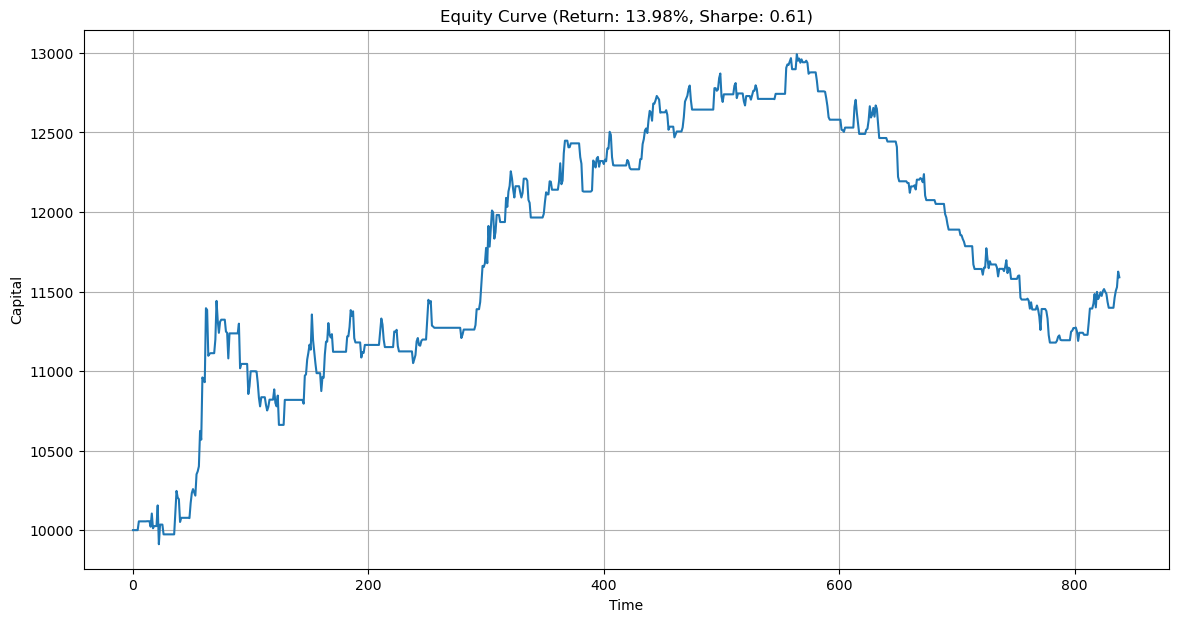

Final capital: $11397.96
Return: 13.98%
Sharpe Ratio: 0.61
Number of trades: 74


In [15]:
trades, equity_curve = backtest_trading_strategy(results["actual"], results["pred"])